# Examplary office Chilled Water consumption prediction usning LSTM Model

Energy consumption forecasting for buildings has immense value in energy efficiency and sustainability research. Accurate energy forecasting models have numerous implications in planning and energy optimization of buildings and campuses. For new buildings, where past recorded data is unavailable, computer simulation methods are used for energy analysis and forecasting future scenarios. However, for existing buildings with historically recorded time series energy data, statistical and machine learning techniques have proved to be more accurate and quick

## Imports

In [7]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)

import warnings

import datetime as dt
from IPython.display import HTML # to see everything
warnings.filterwarnings("ignore")

Import sklearn and statsmodels 

In [3]:
# import sklearn 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

Import tensorflow and Keras

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta0
2.2.4-tf


Import my functions

In [5]:
import supervised_learning as sl
import visualization as vis
%load_ext autoreload
%autoreload 2

## Load Dataset -- Hot Water

In [194]:
office = pd.read_csv('data_folder/cleaned_office_data.csv', index_col=['timestamp'], parse_dates=['timestamp']) 
print('Dataset record for building_id = 1249:', office.shape)
hw_consumption = office[office['meter']==3]
# hw_consumption =hw_consumption.drop('meter')
hw_consumption.head()                        

Dataset record for building_id = 1249: (35136, 9)


meter  meter_reading  air_temperature  cloud_coverage  \
timestamp                                                                    
2016-01-01 00:00:00      3        840.861            5.600           0.000   
2016-01-01 01:00:00      3        942.818            5.600           0.000   
2016-01-01 02:00:00      3        833.966            5.600           4.000   
2016-01-01 03:00:00      3        941.321            5.600           4.000   
2016-01-01 04:00:00      3       1008.240            5.000           4.000   

                     dew_temperature  precip_depth_1_hr  sea_level_pressure  \
timestamp                                                                     
2016-01-01 00:00:00           -0.600              0.000            1019.500   
2016-01-01 01:00:00           -0.600              0.000            1019.500   
2016-01-01 02:00:00           -0.600              0.000            1019.500   
2016-01-01 03:00:00           -1.100              0.000            1019.500   
2016-01-01 04:00:00           -2.200              0.000            1019.000   

                     wind_direction  wind_speed  
timestamp                                        
2016-01-01 00:00:00         300.000       2.600  
2016-01-01 01:00:00         300.000       2.600  
2016-01-01 02:00:00         300.000       2.600  
2016-01-01 03:00:00         300.000       1.500  
2016-01-01 04:00:00         290.000       3.100

perform forward and backward fill for missing time-series observations

In [161]:
# cols = list(office.columns)
# cols.remove('meter_reading')
# cols.remove('meter')
# office[cols]=office[cols].ffill()
# office[cols]=office[cols].bfill()
# # office_new = office.cols.ffill()
# print(office.shape)
# # office.head()
# office.to_csv(r'data_folder/cleaned_office_data.csv')

(35136, 9)


There is 403 observation with zero meter reading which might be right and now we do not have any missing values. I took out 'Hot Water" meter reading and do some explanatory data analysis. 

## Exploratory Data Analysis or (EDA)

In [172]:
# %load -r 14-27 visualization.py

The energy consumption is in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

In [12]:
# plot 
# vis.median_meter_reading(office_data)
# plt.savefig('image/meter_reading_by_type')

### Box plots and outlier detection

In [189]:
# B=plt.boxplot(hw_consumption.meter_reading)
# [item.get_ydata() for item in B['whiskers']]

In [188]:
# %load -r 117-131 visualization.py

In [187]:
# rolling_statistics(hw_consumption['meter_reading'])

In [182]:
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

In [ ]:
# !jupyter labextension install jupyterlab-dash@0.1.0-alpha.3 --user

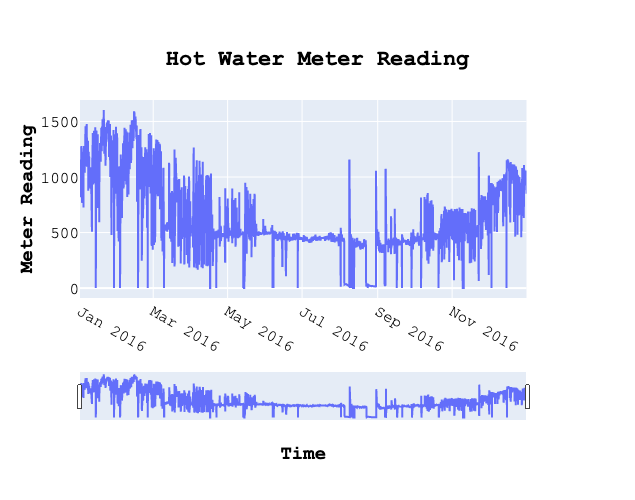

In [259]:
# Make subplot figure 
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=hw_consumption.index,
                         y=hw_consumption['meter_reading'],
                         name="Actual")) #line_color='darkblue'
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(width=1000, height=500,
                      title= {'text': "<b>Hot Water Meter Reading<b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="<b>Time<b>",
                      yaxis_title="<b>Meter Reading<b>",
                      font=dict(family="Courier New, monospace", size=16, color='black'))
fig.show()

## Features and labels
for this capstone project, I wanted to build a model that will predict the future energy consumption and air temperature variation as a function of all other eight features.

In [205]:
target_names = ['meter_reading']#, 'air_temperature']
shift_days = 1
shift_steps = shift_days * 24 # I wanted to shift the record by shift_steps hours.
df_targets = hw_consumption[target_names].shift(-shift_steps)
df_targets.head(3)

meter_reading
timestamp                         
2016-01-01 00:00:00       1164.430
2016-01-01 01:00:00       1277.750
2016-01-01 02:00:00       1167.290

to check we successfully shifted by 24 hours, I took the 24 to 27 records from the original data

In [206]:
# check the raws from 24- 27
hw_consumption[target_names].iloc[24:27]

meter_reading
timestamp                         
2016-01-02 00:00:00       1164.430
2016-01-02 01:00:00       1277.750
2016-01-02 02:00:00       1167.290

good! new we succesfully shifted by 24 hours, let us split the data set into feature and target.

In [207]:
# features
x_data = hw_consumption.values[0:-shift_steps]
print('    Feature Shape:', x_data.shape)
 
# target
y_data = df_targets.values[:-shift_steps]
print('    Target Shape:', y_data.shape)

    Feature Shape: (8760, 8)
    Target Shape: (8760, 1)


In [208]:
hw_consumption.head(3)

meter_reading  air_temperature  cloud_coverage  \
timestamp                                                             
2016-01-01 00:00:00        840.861            5.600           0.000   
2016-01-01 01:00:00        942.818            5.600           0.000   
2016-01-01 02:00:00        833.966            5.600           4.000   

                     dew_temperature  precip_depth_1_hr  sea_level_pressure  \
timestamp                                                                     
2016-01-01 00:00:00           -0.600              0.000            1019.500   
2016-01-01 01:00:00           -0.600              0.000            1019.500   
2016-01-01 02:00:00           -0.600              0.000            1019.500   

                     wind_direction  wind_speed  
timestamp                                        
2016-01-01 00:00:00         300.000       2.600  
2016-01-01 01:00:00         300.000       2.600  
2016-01-01 02:00:00         300.000       2.600

In [209]:
# These are the input-signals for the training- and test-sets:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print('Training observations:', num_train)
print('Validation observations:', num_test)
x_train = x_data[0:num_train]
x_test  = x_data[num_train:]
print('Total observations:', (len(x_train) + len(x_test)))

Training observations: 7446
Validation observations: 1314
Total observations: 8760


In [210]:
# Check the shape
x_train.shape, x_test.shape

((7446, 8), (1314, 8))

In [211]:
# These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print('Total test observations:', (len(y_train) + len(y_test)))
y_train.shape, y_test.shape

Total test observations: 8760


((7446, 1), (1314, 1))

In [212]:
num_x_signals = x_data.shape[1] # 8
num_y_signals = y_data.shape[1] # 2
print('Number of input-signals:', num_x_signals, 'and shape:', x_train.shape )
print('Number of output-signals:', num_y_signals, 'and shape', y_train.shape)

Number of input-signals: 8 and shape: (7446, 8)
Number of output-signals: 1 and shape (7446, 1)


## Scaled Data

In [213]:
# x_data[24:27] # I shifted the data by one day

In [214]:
print('Min and Max x_train data')
print('    Min:', np.min(x_train))
print('    Max:', np.max(x_train))
x_scaler = MinMaxScaler() # feature_range=(0, 1)
x_scaled_train = x_scaler.fit_transform(x_train)
print('Min and Max x_train_scaled data')
print('    Min:', np.min(x_scaled_train))
print('    Max:', np.max(x_scaled_train))

Min and Max x_train data
    Min: -25.6
    Max: 1604.06
Min and Max x_train_scaled data
    Min: 0.0
    Max: 1.0


In [215]:
x_scaled_test = x_scaler.transform(x_test)
print('Min and Max x_test data')
print('    Min:', np.min(x_test))
print('    Max:', np.max(x_test))

# target MinMaxScaler
y_scaler = MinMaxScaler() # feature_range=(-1, 1)
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)
print('Min and Max y_test_scaled data')
print('    Min:', np.min(y_scaled_test))
print('    Max:', np.max(y_scaled_test))

Min and Max x_test data
    Min: -23.3
    Max: 1223.9
Min and Max y_test_scaled data
    Min: 0.0
    Max: 0.7630013839881302


In [216]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('-------')
print(x_scaled_test.shape)
print(y_scaled_test.shape)
# y_train_scaled

(7446, 8)
(7446, 1)
-------
(1314, 8)
(1314, 1)


The data we have now is one long-time series with 20 input signals so that each time step has 8 input signals and 2 output signals

## Data Generator

In [217]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)

(7446, 8)
(7446, 1)


call the batch generator function and create a training bach

In [218]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_scaled_train[idx:idx+sequence_length]
            y_batch[i] = y_scaled_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

The above function will break the long-time series signal into small subsequences and create a batch so that we can use that for training the network

```python
reshape input to be [samples, time steps, features]
```

In [219]:
# reshape input to be [samples, time steps, features]
batch_size = 64 # batch size of 32 is a good starting point, and you should also try with 64, 128, and 256.
sequence_length = shift_steps # 24 * 7

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(64, 24, 8)
(64, 24, 1)


we get a batch output where we have a batch size of 64 sequences, each sequence has 24, and 8 input signals and 2 output signals. 

I create a validation dataset from the testing data

In [220]:
validation_data = (np.expand_dims(x_scaled_test, axis=0),
                   np.expand_dims(y_scaled_test, axis=0))

In [221]:
print('x_test_validation', validation_data[0].shape)
print('y_test_validation', validation_data[1].shape)

x_test_validation (1, 1314, 8)
y_test_validation (1, 1314, 1)


## Create the Recurrent Neural Network Architecture

In [222]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                               TensorBoard, ReduceLROnPlateau, CSVLogger)

### Initalize the RNN
Now let us instantiate an RNN model

In [223]:
# clear a model
tf.keras.backend.clear_session()

In [224]:
# Initializing RNN 
hw_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [225]:
from keras import regularizers

Using TensorFlow backend.


In [226]:
# Adding the first LSTM layer and some Dropout regularisation
hw_dropout_model.add(LSTM(units=100, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
                            input_shape=(None, num_x_signals,)))
hw_dropout_model.add(Dropout(0.2))
# model.summary()

In [227]:
# Adding the second LSTM layer and some Dropout regularisation
hw_dropout_model.add(LSTM(units=100, return_sequences=True #kernel_regularizer=regularizers.l2(0.01), 
                            ))
hw_dropout_model.add(Dropout(0.2))
# model.summary()

In [229]:
hw_dropout_model.add(Dense(num_y_signals, activation='sigmoid')) #, kernel_regularizer=regularizers.l2(0.01),


### Loss Function

load the loss_mse_warmup function below

In [74]:
# %load -r 41-63 supervised_learning.py

### Compile Model

In [231]:
optimizer = RMSprop(lr=1e-3)

In [232]:
hw_dropout_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
hw_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         43600     
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 124,101
Trainable params: 124,101
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [233]:
path_checkpoint = 'weights/model_weights_hw_dropout.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [234]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False) #'./23_logs/'

In [235]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [236]:
csv_logger = CSVLogger('logs/hw_dropout_model.csv')

In [237]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

### Fit the RNN to the training set 

In [238]:
%%time
hw_dropout_history = hw_dropout_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 99/100 [============================>.] - ETA: 0s - loss: 0.0172 - mse: 0.0172
Epoch 00001: val_loss improved from inf to 0.01004, saving model to weights/model_weights_hw_dropout.h5
100/100 [==============================] - 17s 175ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0103 - mse: 0.0103
Epoch 00002: val_loss did not improve from 0.01004

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 8s 79ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0091 - mse: 0.0091
Epoch 00003: val_loss did not improve from 0.01004

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [========================

### Evaluate the model

In [240]:
# evaluete training set
hw_dropout_model.evaluate(x_batch, y_batch)

64/64 [==============================] - 1s 13ms/sample - loss: 0.0054 - mse: 0.0054


[0.005390641512349248, 0.0053906417]

In [243]:
# evaluate test set
hw_dropout_model.evaluate(validation_data[0], validation_data[1])
print('validation set should be a 3D arrray', 
      validation_data[0].shape, validation_data[1].shape)

1/1 [==============================] - 2s 2s/sample - loss: 0.0107 - mse: 0.0107
validation set should be a 3D arrray (1, 1314, 8) (1, 1314, 1)


In [244]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('-----')
print(x_scaled_test.shape)
print(y_scaled_test.shape)
type(x_scaled_train)

(7446, 8)
(7446, 1)
-----
(1314, 8)
(1314, 1)


numpy.ndarray

In [247]:
# this is also a validation test
result = hw_dropout_model.evaluate(x=np.expand_dims(x_scaled_test, axis=0),
                        y=np.expand_dims(y_scaled_test, axis=0))

1/1 [==============================] - 2s 2s/sample - loss: 0.0107 - mse: 0.0107


In [248]:
print("loss (test-set):", result)

loss (test-set): [0.010724428109824657, 0.010724428]


load plot comparision plot

In [250]:
# %load -r 43-102 visualization.py

In [253]:
date_train = hw_consumption.index[:num_train]
date_test = hw_consumption.index[num_train:-shift_steps]
print(len(date_train))
print(len(date_test))

7446
1314


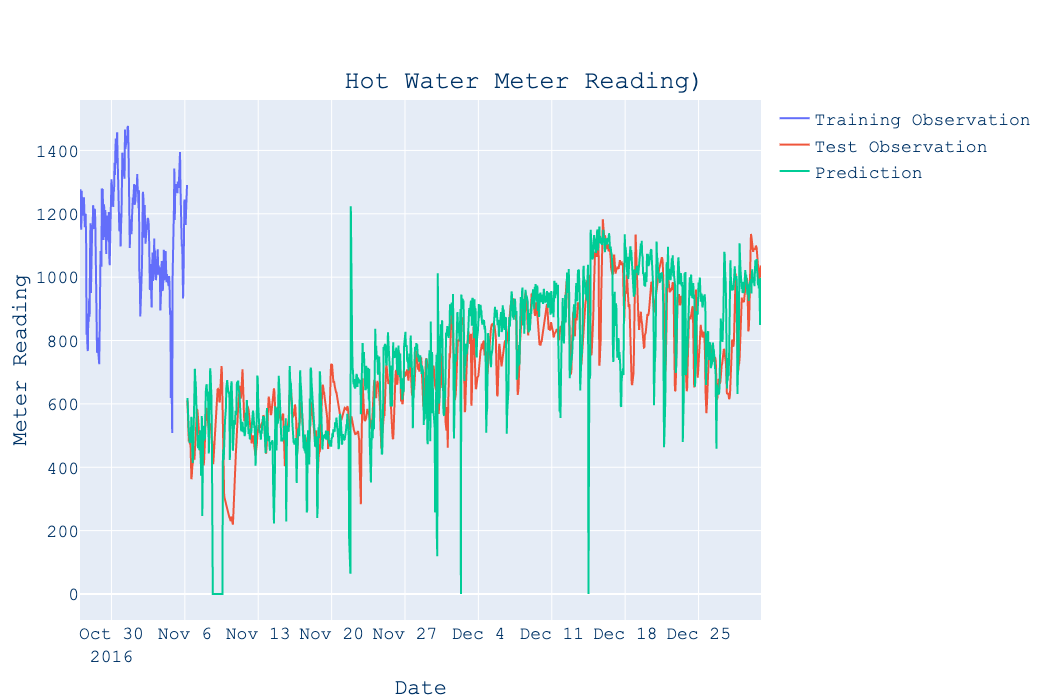

In [254]:
x = np.expand_dims(x_scaled_test, axis=0)
y_pred = hw_dropout_model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


y_train_reshaped = y_train.reshape((-1))
y_test_reshaped = y_test.reshape((-1))
y_pred_reshaped = y_pred_rescaled.reshape((-1))

trace1 = go.Scatter(
    x = hw_consumption.index[7200:num_train],
    y = y_train_reshaped,
    mode = 'lines',
    name = 'Training Observation'
)
trace2 = go.Scatter(
    x = date_test,
    y = y_pred_reshaped,
    mode = 'lines',
    name = 'Test Observation'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test_reshaped,
    mode='lines',
    name = 'Prediction'
)
layout = go.Layout(width=1400, height=700,
    title = {'text': "Hot Water Meter Reading)", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Meter Reading", }
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(font=dict(family="Courier New, monospace", size=18, color="#003366", )) # "#7f7f7f"
# fig.write_image('image/time_series_forcast_chw.png')
fig.show()

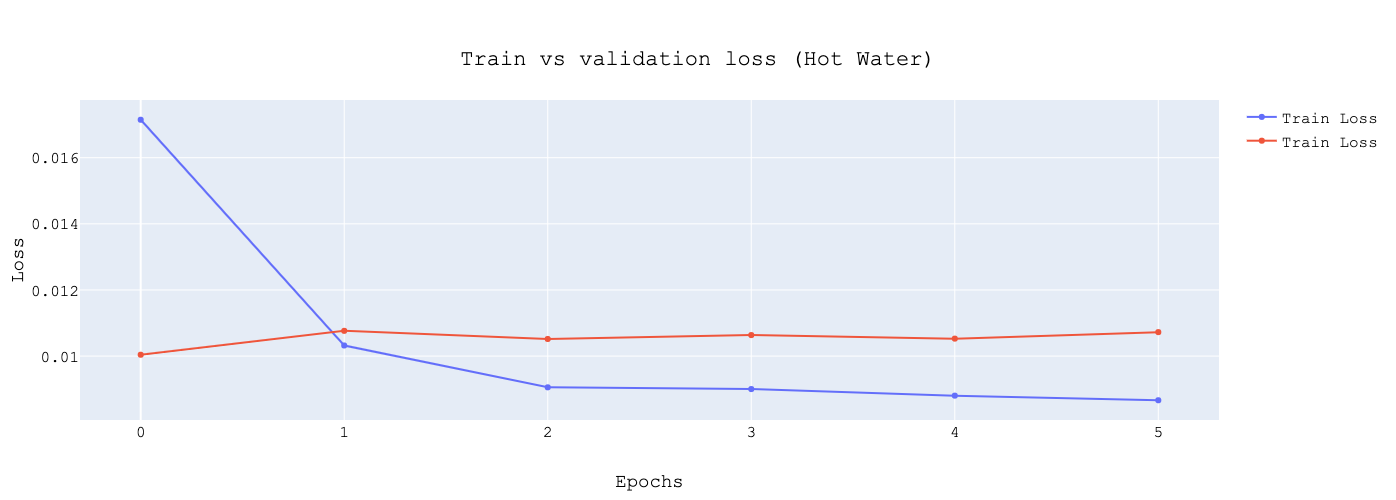

In [256]:
vis.plot_train_vs_val_loss(history=hw_dropout_history, a='Hot Water')

In [276]:

def plot_train_vs_val_loss(history=None, a=None):
    """
    plot model accuracy, comparing training and testing accuracies.
    Arguments:
        history: model history 
    Outputs:
        MSE loss plot 
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history['loss'], name="Train Loss"))
    fig.add_trace(go.Scatter(y=history.history['val_loss'], name="Train Loss"))
    fig.update_layout(width=1000, height=500,
                      title= {'text': "Train vs validation loss ({})".format(a),
                              'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="Epochs",
                      yaxis_title="Loss",
                      font=dict(family="Courier New, monospace", size=16, color='black')
                     )
#     fig.write_image('image/train2.png')
    fig['layout']['yaxis1'].update(range=[0, 0.05], autorange=False)
    fig.show();

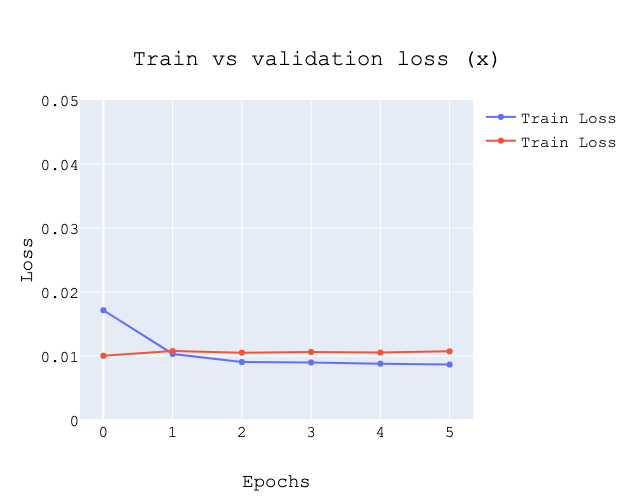

In [277]:
plot_train_vs_val_loss(hw_dropout_history, a='x')

In [251]:
fig = go.Figure()
# y_axis = chw_consumption['meter_reading']
rolmean = y_axis.rolling(window=7, center=False).mean()
rolstd = y_axis.rolling(window=7, center=False).std()

fig.add_trace(go.Scatter(x=chw_consumption.index, y=y_axis,
                         name="Original", line_color='blue'))

fig.add_trace(go.Scatter(x=y_test_df.index, y=rolmean,
                         name="Rolling Mean", line_color='red'))
fig.add_trace(go.Scatter(x=y_test_df.index, y=rolstd,
                         name="Rolling Mean", line_color='black'))

fig.update_layout(width=1000, height=500,
                  title= {'text': "Rolling Mean & Standard Deviation",
                          'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},                    
#                   xaxis_title="Year-2016",
                  yaxis_title="Meter reading (kWh)",
                  font=dict(family="Courier New, monospace",
                            size=16, color='black', )
                 )

NameError: name 'y_axis' is not defined

In [110]:
x = x_scaled_train[4000:5000]
print(x_scaled_train.shape)
print(x.shape)
x_3d = np.expand_dims(x, axis=0)
print(x_3d.shape)

(7446, 8)
(1000, 8)
(1, 1000, 8)


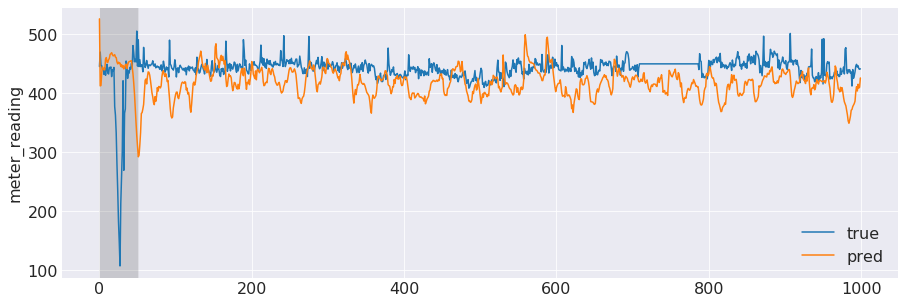

In [106]:
plot_comparison(start_idx=4000, length=1000, train=True, model=hw_dropout_model)

In [111]:
def plot_comparison_plotly(start_idx, length=100, train=True, model=None):
    
    if train:
        x = x_scaled_train
        y_true = y_train
    else:
        x = x_scaled_test
        y_true = y_test
    
    
    end_idx = start_idx + length
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        fig = go.Figure()
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]

#         plt.figure(figsize=(15,5))
        fig.add_trace(go.Scatter(x=x, y=signal_true, name='true'))
        fig.add_trace(go.Scatter(x=x, y=signal_pred, name='pred'))
        fig.update_layout(title=target_names[signal])
        fig.show()


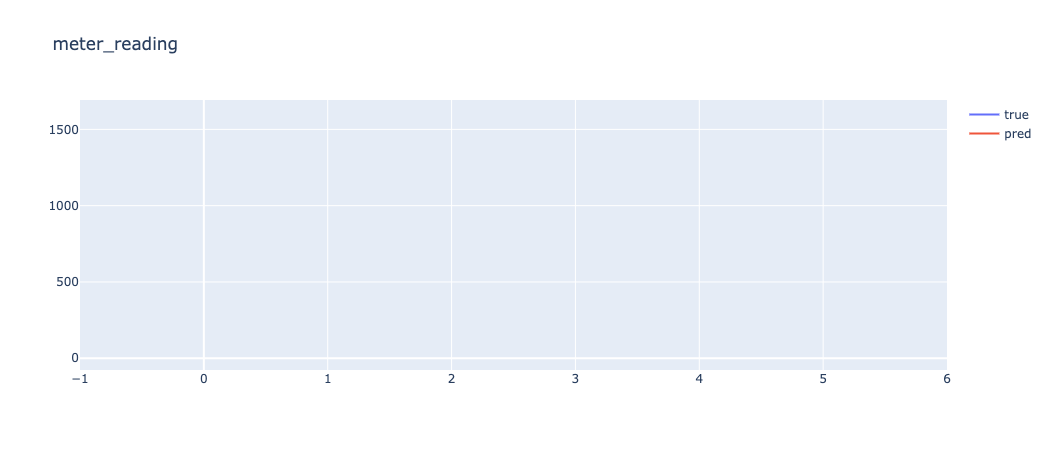

In [112]:
plot_comparison_plotly(start_idx=0, length=8000, train=True, model=hw_dropout_model)

### Example from test set

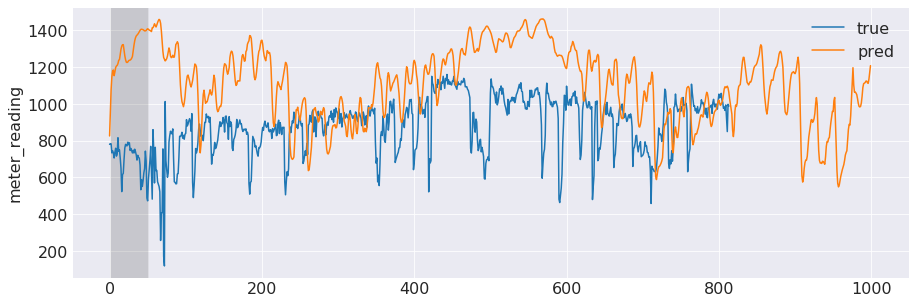

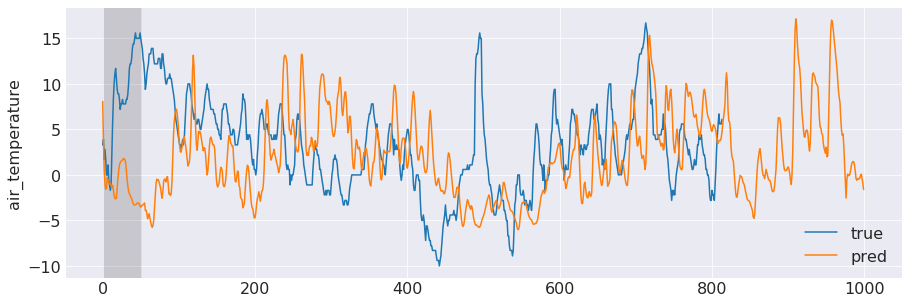

In [59]:
plot_comparison(start_idx=500, length=1000, train=False, model=hw_dropout_model)

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [60]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [63]:
calculate_errors(train=True, model=hw_dropout_model)

Traning data:
    Mean Absolute Error: 85.38573600534855
    Root Mean Squared Error: 131.07867240415237
    Mean Absolute Error: 3.069346230070582
    Root Mean Squared Error: 3.9353723842410644


In [64]:
calculate_errors(train=False, model=hw_dropout_model)

Testing data:
    Mean Absolute Error: 95.29072428894507
    Root Mean Squared Error: 130.1097814322085
    Mean Absolute Error: 3.5715430131646317
    Root Mean Squared Error: 4.50309933578638


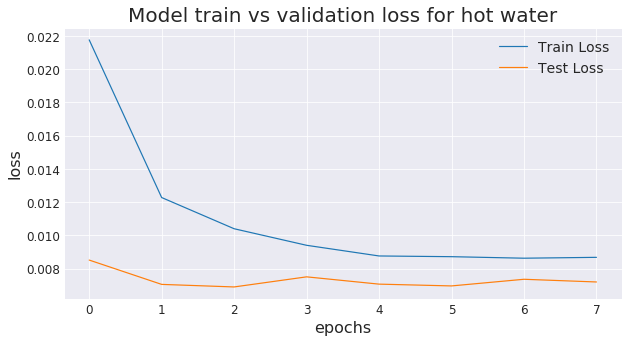

In [70]:
plt.figure(figsize=(10,5))
plt.plot(hw_dropout_history.history['loss'], label='Train Loss')
plt.plot(hw_dropout_history.history['val_loss'], label='Test Loss')
plt.title('Model train vs validation loss for hot water', fontsize=20)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.savefig('image/model_loss_hw')
plt.show();

In [ ]:
def 

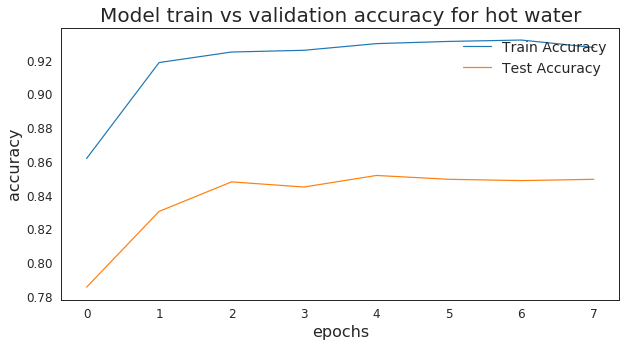

In [67]:
plt.figure(figsize=(10,5))
plt.plot(hw_dropout_history.history['acc'], label='Train Accuracy')
plt.plot(hw_dropout_history.history['val_acc'], label='Test Accuracy')
plt.title('Model train vs validation accuracy for hot water', fontsize=20)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.show();

# # 2nd_LSTM Model
this model uses an upgrade on batch size
- softmax activation
- optimizer adam 
- batch size 72

In [ ]:
# reshape input to be [samples, time steps, features]
batch_size = 64
# sequence_length = shift_steps # 24 * 7

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
# reshape input to be [samples, time steps, features]
# batch_size_2 = 30
# sequence_length = shift_steps # 24 * 7

# create the batch-generator
# generator_2 = batch_generator(batch_size_2, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

In [ ]:
# clear a model
tf.keras.backend.clear_session()

In [ ]:
# Initializing RNN 
chw_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [ ]:
# Adding the first LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=50, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
#                            activity_regularizer=regularizers.l1(0.01),
                           input_shape=(None, num_x_signals,)))
chw_dropout_model.add(Dropout(0.4))
# model.summary()

In [ ]:
# Adding the second LSTM layer and some Dropout regularisation
chw_dropout_model.add(LSTM(units=50, return_sequences=True, #kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)
                          ))
chw_dropout_model.add(Dropout(0.4))
# model.summary()

In [ ]:
chw_dropout_model.add(Dense(num_y_signals, activation='sigmoid', #kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)
                           ))

if False:
    from tensorflow.python.keras.initializers import RandomUniform

#     # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05) # I ca

    chw_dropout_model.add(Dense(num_y_signals,
                                activation='linear', #kernel_regularizer=regularizers.l2(0.01), #linear
                                #activity_regularizer=regularizers.l1(0.01),
                                kernel_initializer=init))

In [ ]:
# optimizer = RMSprop(lr=1e-3)
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

In [ ]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['acc'])
chw_dropout_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
chw_dropout_model.summary()

### Fitting the model

In [ ]:
csv_logger = CSVLogger('logs/chw_dropout_model.csv')

In [ ]:
path_checkpoint = 'weights/model_weights_chw_dropout.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

In [ ]:
%%time
chw_dropout_history = chw_dropout_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=50, #100,
                    validation_data=validation_data,
                    callbacks=callbacks)

# Evaluating the model

In [ ]:
chw_dropout_model.evaluate(validation_data[0], validation_data[1])

In [ ]:
chw_dropout_model.evaluate(x_batch, y_batch)

In [ ]:
# x_sis.shape, y_sis.shape

In [ ]:
# compare_cx = data.frame(
#     baseline_train = history.history['loss'],
#     baseline_val = history.history['val_loss'],
#     dropout_train = dropout_history.history['loss'],
#     dropout_val = dropout_history.history['val_loss'])
# ) %>%

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(chw_dropout_history.history['loss'], label='Train Loss')
plt.plot(chw_dropout_history.history['val_loss'], label='Test Loss')
plt.title('Model loss vs validation loss', fontsize=20)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.show();

# Overfitting and underfitting

The accuracy of our model on the validation data would peak after training for a number of epochs, and would then start decreasing.

In other words, our model would overfit to the training data. Learning how to deal with overfitting is important. Although it’s often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to testing data (or data they haven’t seen before).

there are two common regularization techniques - weight regularization and dropout 

In [ ]:
# from builtins import *
# from pyensae.languages.rconverter import r2python

In [ ]:
# !sudo pip install antlr4-python2-runtime

In [ ]:
# !pip install pyensae --user
# !sudo pip install antlr4-python2-runtime

In [ ]:
# list all data in history
print(chw_dropout_history.history.keys())
# summarize history for accuracy
plt.plot(chw_dropout_history.history['acc'])
plt.plot(chw_dropout_history.history['val_acc'])
plt.title('Model vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(chw_dropout_history.history['loss'])
plt.plot(chw_dropout_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [ ]:
plot_comparison(start_idx=4000, length=1000, train=True, model=chw_dropout_model)

### Example from test set

In [ ]:
plot_comparison(start_idx=1000, length=1000, train=False, model=chw_dropout_model)

In [ ]:
calculate_errors(train=True, model=chw_baseline_model)

In [ ]:
calculate_errors(train=True, model=chw_baseline_model)

### Measuring and ploting RMSE

#### Finding Fedaral Holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [ ]:
df = df_elc.copy()
df = df.reset_index()
df['days'] = df.timestamp.apply(lambda x:1 if x.dayofweek > 5 else 0)
df.days.value_counts()

In [ ]:
cal = calendar()
holidays = cal.holidays(start = df.timestamp.min(), end = df.timestamp.max())
df["holiday"] = df.timestamp.isin(holidays).astype('int')
df.head(3)

#### -- start

As a first step, I instantiate the Sequential class. This will be my model class and I will add LSTM, Dropout and Dense layers to this model. 

the output of the last layer is a tensor with an aritrary batch size and arbitrary sequance length and two output length signals. 